In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import math
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from dataset import get_dataset
from utils import alphabar_t
# from model import Model
from generate import train_sample
from model import Unet
import os

torch.backends.cudnn.benchmark = True


/home/bigbrainman/deepvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 150
S = 0.0008
BATCH_SIZE = 128
IMAGE_SIZE = 32
CHANNELS = 1
SPLIT = 'digits'

In [3]:
train_set = get_dataset(T, image_size=IMAGE_SIZE, split=SPLIT)

In [4]:
len(train_set)

240000

In [5]:
g = make_grid([train_set[random.randint(0, len(train_set) -1)][2] for _ in range(25)], 5)

torch.Size([1, 32, 32])


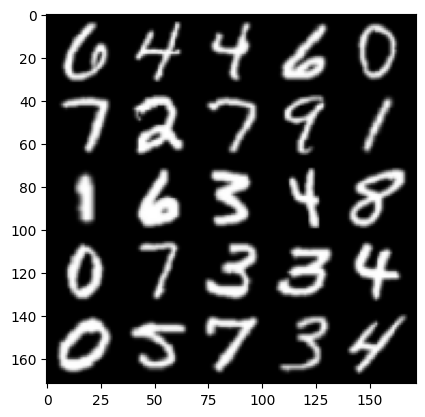

In [6]:
plt.imshow(g.permute(1, 2, 0))
print(train_set[0][0].shape)

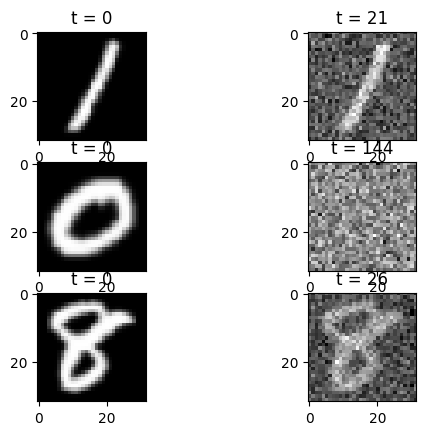

In [7]:
fig, axes = plt.subplots(3, 2)

for i in range(3):
    idx = random.randint(1, T - 1)
    axrow = axes[i]

    noise_img, eps, img, t = train_set[idx]

    axrow[0].imshow(img.permute(1, 2, 0), cmap='gray')
    axrow[0].set_title('t = 0')

    axrow[1].imshow(noise_img.permute(1, 2, 0), cmap='gray')
    axrow[1].set_title(f"t = {t}")

In [8]:
# net = Model(u_depth = 5, block_size=3, h_channels = 10).to(device)


net = Unet(
    channels=CHANNELS,
    u_depth=4
).to(device)

iters = 0

model_dir = './models'

if os.path.exists(model_dir) and len(list(os.walk(model_dir))[0][2]) >= 2 and False:

    highest = 0
    for p in list(os.walk(model_dir))[0][2]:
        
        highest = max(highest, int(os.path.splitext(p)[0]))

    print(f"loading {highest}")
    path = f'{model_dir}/{highest}.pth'
    print(path)
    net.load_state_dict(torch.load(path))
    iters = highest

# summary(net, (CHANNELS, IMAGE_SIZE, IMAGE_SIZE), device=device)



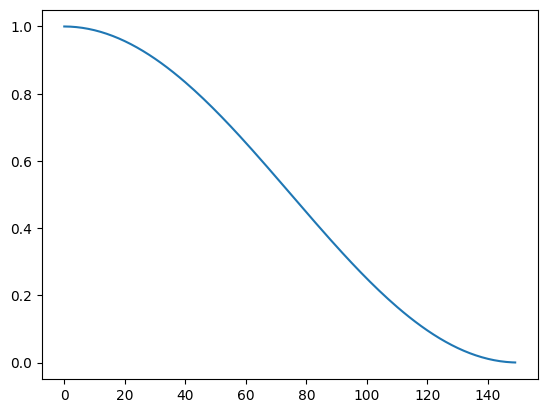

In [9]:
# precache the alpha_bars
a_bar = alphabar_t(torch.arange(0, T), T, S)

plt.plot(a_bar)


In [10]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
loss_fn = torch.nn.HuberLoss()
optim = torch.optim.Adam(net.parameters(), lr=6e-5)

In [22]:
iters_print = 20

iters_generate = 100

for i in range(100):
    print_loss = 0

    for noise_img, eps, img, t in train_dl:


        noise_img = noise_img.to(device)
        eps = eps.to(device)
        t = t.to(device)

        net.train()

        out = net(noise_img, t)

        loss = loss_fn(out, eps)

        optim.zero_grad()

        loss.backward()

        optim.step()

        print_loss += loss.item()


        iters += 1

        if iters % iters_print == 0:
            l = print_loss / iters_print
            print_loss = 0
            print(f"[iter {iters}] loss: {l}")


        if iters % iters_generate == 0:
            torch.save(net.state_dict(), f'./models/{iters}.pth')
            net.eval()
            with torch.no_grad():
                train_sample(20, T, net, iters, shape=(CHANNELS, IMAGE_SIZE, IMAGE_SIZE))


[iter 6680] loss: 0.010008669132366777
[iter 6700] loss: 0.010367704089730978


100%|██████████| 149/149 [00:01<00:00, 129.36it/s]


[iter 6720] loss: 0.010649857576936483
[iter 6740] loss: 0.010315419919788838
[iter 6760] loss: 0.010348830651491881
[iter 6780] loss: 0.010341392271220684
[iter 6800] loss: 0.010336220264434814


100%|██████████| 149/149 [00:01<00:00, 128.77it/s]


[iter 6820] loss: 0.010055834101513028
[iter 6840] loss: 0.009892344940453768
[iter 6860] loss: 0.009847531467676163
[iter 6880] loss: 0.010668673366308213
[iter 6900] loss: 0.010159868141636252


100%|██████████| 149/149 [00:01<00:00, 130.44it/s]


[iter 6920] loss: 0.010411825543269516
[iter 6940] loss: 0.010308916028589011
[iter 6960] loss: 0.010529280407354236
[iter 6980] loss: 0.010238792514428496
[iter 7000] loss: 0.009842812456190586


RuntimeError: [enforce fail at inline_container.cc:319] . unexpected pos 8077632 vs 8077528